# Directed Erdos-Renyi link community walkthrough
Authored by Jorge S. Martinez Armas.

This notebook demonstrates how to run the LinkNodeCommunity algorithm on a synthetic directed Erdos-Renyi graph. The aim is to illustrate how the hierarchy of link communities is built and how the density (`D`) and loop entropy (`S`) statistics behave.

We proceed step by step:
1. import the required Python wrappers,
2. generate a random graph and fit the hierarchical model, and
3. read the hierarchy through plots and partitions selected by maximizing `D` or `S`.

Both statistics are defined in Martinez-Armas et al. (2024). For convenience we summarize `S` as the Shannon entropy of the fraction of excess edges assigned to each link community; you do not need to inspect the C++ backend to follow along. Short explanations accompany each code block so that a reader new to the algorithm can reproduce the workflow without digging into implementation details.


In [1]:
# Standard Python libs ----
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
import sys

# Add the parent directory to sys.path so src can be imported
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import LinkNodeCommunity as lnc
from src.viz.graphics import (
    link_statistics_graph,
    linkcommunity_matrix_map,
    dendrogram
)

## Step 1 · Generate a directed Erdos-Renyi graph
We draw a G(N, M) random graph with fixed density `rho`. For a directed network the maximum number of possible edges is `N * (N - 1)`, so we sample `M = rho * N * (N - 1)` edges uniformly at random. The random seed keeps the example reproducible.

Key parameters:
- `rho`: density of the directed network.
- `N`: number of nodes.
- `M`: number of sampled directed edges.
- `seed`: random generator seed.

After the graph is created we label the nodes and instantiate the LinkNodeCommunity clustering model.


In [2]:
rho = 0.6                                                   # Network density
N = 50                                                      # Number of nodes
M = int(N * (N - 1) * rho)                                  # Number of edges
seed = 12321                                                # Random seed
G = nx.gnm_random_graph(N, M, seed=seed, directed=True)     # Create random graph using networkx


assert not any(G.has_edge(n, n) for n in G.nodes), "Graph G contains self-loops."

labels = np.arange(N).astype(int).astype(str)               # Create the nodes' labels

labels_dict = dict()
for i in np.arange(N):
  labels_dict[i] = labels[i]

## Step 2 · Fit the link hierarchy model
The clustering model builds a hierarchy over the edges by comparing link similarity scores. The call to `process_features_edgelist` records the link statistics at every merge. Internally, the loop entropy `S` is obtained via the C++ routine mentioned above, which computes the information content of excess edges relative to a spanning-tree baseline.

The object `link_hierarchy_statistic` now stores, for each level `K`, the values of D (average community density), S (loop entropy), and other bookkeeping quantities.


In [3]:
# LinkNodeCommunity model fitting
model = lnc.Clustering(G, similarity_index="tanimoto_coefficient", edge_complete=False)
model.fit(use_parallel=True, method="edgelist", max_dist=1.0, verbose=1)

[linksim] Initialized with N=50, M=1470, verbose=1
[linksim] Starting fit_linksim_edgelist()
[linksim] Completed fit_linksim_edgelist()
[linkstat] Initialized with N=50, M=1470, verbose=1, force=0, edge_complete=0
[linkstat] Starting fit_edgelist workflow
[linkstat] Completed fit_edgelist workflow
[link2node] Initialized with N=50, M=1470, verbose=1, edge_complete=0
[link2node] Starting fit_edgelist workflow
[link2node] Starting fit_edgelist_directed workflow
[link2node] Completed fit_edgelist_directed workflow
[link2node] Completed fit_edgelist workflow


## Step 3 · Inspect hierarchy-level statistics

The two panels show how the number of link communities `K` relates to our scores.
- `D` (left) measures how many excess links each community carries relative to a tree with the same nodes. Higher values indicate denser-than-expected link bundles.
- `S` (right) computes the Shannon entropy of the excess-link probabilities `p_c = (m_c - n_c + 1)/(M - N + 1)` plus the tree remainder. It is largest when those probabilities are comparable across communities.

Trace both curves together to anticipate which dendrogram levels will be highlighted when maximizing each score.


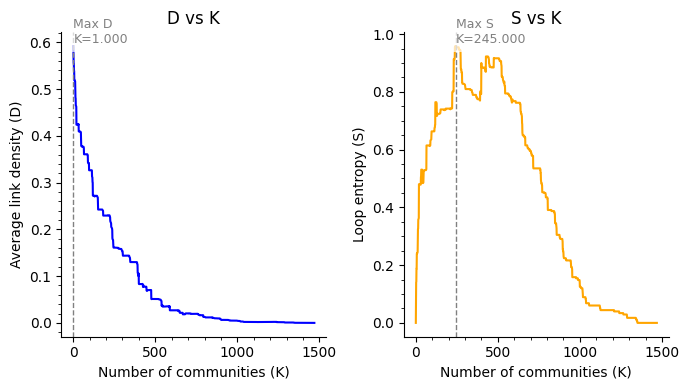

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4))
link_statistics_graph(
    linkstats=model.linkstats,
    x="K",
    y="D",
    xlabel="Number of communities (K)",
    ylabel="Average link density (D)",
    color="blue",
    ax=axes[0]
)

link_statistics_graph(
    linkstats=model.linkstats,
    x="K",
    y="S",
    xlabel="Number of communities (K)",
    ylabel="Loop entropy (S)",
    color="orange",
    ax=axes[1]
)
fig.tight_layout()
plt.show()

## Step 4 · Compare the partitions picked by each score
`linknode_equivalence_partition` scans the hierarchy and returns the level that maximizes the requested statistic. The heatmaps below display the link membership matrix at those levels: rows and columns correspond to links, colours encode community assignment, and the black grid lines mark community boundaries.


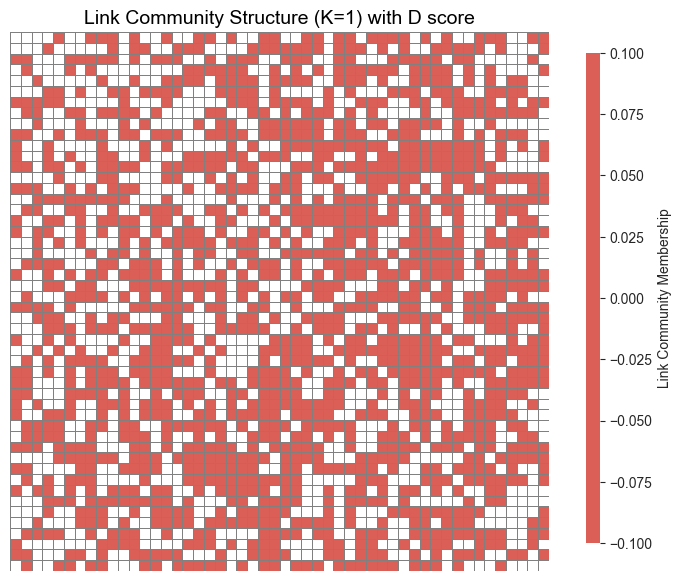

In [5]:
# Link-node equivalence partitioning (D score)
node_partition_dict = model.equivalence_partition(score="D")
node_partition = np.array(list(node_partition_dict.values()))

# Visualize link community structure as a matrix
# Black grid lines mark community boundaries
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
linkcommunity_matrix_map(
    G,
    model.get_hierarchy_edgelist(1.0),
    model.Z,
    model.number_link_communities,
    model.number_node_communities,
    labels=labels[:model.N],
    linewidth=1.75,
    palette="hls",
    remove_labels=True,
    cbar_position=[0.95, 0.15, 0.02, 0.7],
    ax=ax
)
_ = ax.set_title(f"Link Community Structure (K={model.number_link_communities}) with D score", fontsize=14)

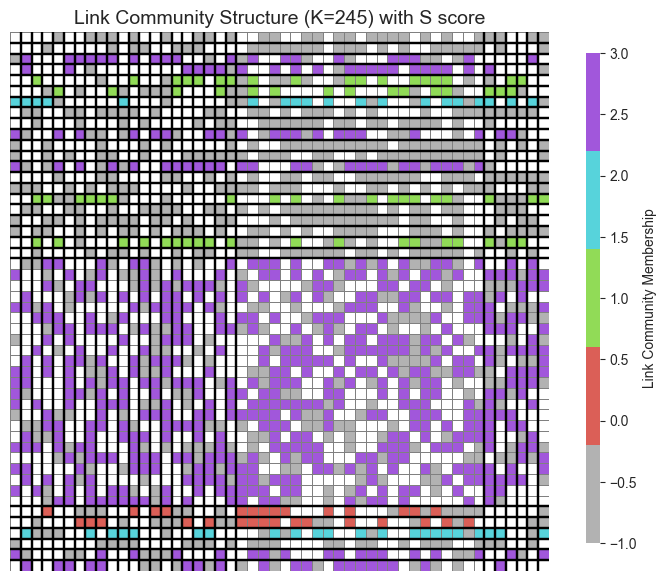

In [6]:
# Link-node equivalence partitioning (S score)
node_partition_dict = model.equivalence_partition(score="S")
node_partition = np.array(list(node_partition_dict.values()))

# Visualize link community structure as a matrix
# Black grid lines mark community boundaries
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
linkcommunity_matrix_map(
    G,
    model.get_hierarchy_edgelist(1.0),
    model.Z,
    model.number_link_communities,
    model.number_node_communities,
    labels=labels[:model.N],
    linewidth=1.75,
    palette="hls",
    remove_labels=True,
    cbar_position=[0.95, 0.15, 0.02, 0.7],
    ax=ax
)
_ = ax.set_title(f"Link Community Structure (K={model.number_link_communities}) with S score", fontsize=14)

## Step 5 · Visualize the level at the maximum S level
The dendrogram focuses on the node partition induced by the S optimum. It helps verify whether the selected cut corresponds to a meaningful branching structure or simply balances one dominant community against the tree remainder.


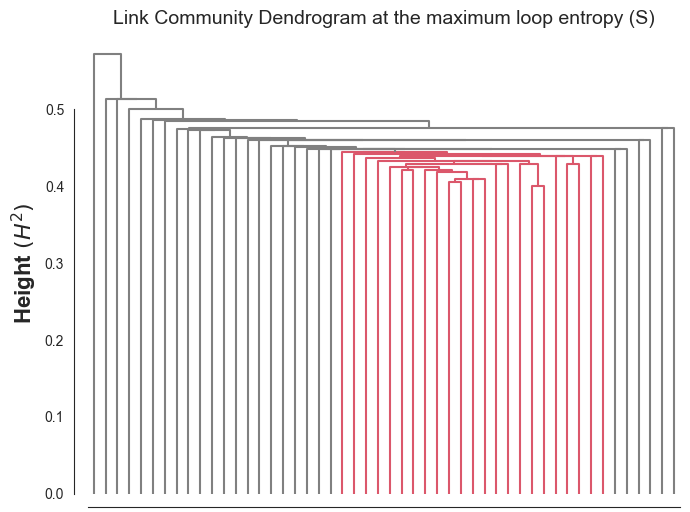

In [7]:
# Dendrogram at the Goldilocks level (S score)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

dendrogram(
    model.Z,
    model.number_node_communities,
    ylabel="Height " + r"$(H^{2})$",
    remove_labels=True,
    ax=ax
)

fig.tight_layout()
_ = ax.set_title("Link Community Dendrogram at the maximum loop entropy (S)", fontsize=14)

## Observations

- Maximizing `D` collapses the hierarchy to the trivial partition (`K = 1`) because aggregating all links maximizes average density in this dense random graph; the membership heatmap therefore shows one block.
- Maximizing `S` balances the dominant community against the tree remainder, making their excess-link probabilities similar and thus increasing entropy. The corresponding heatmap confirms that this cut still splits off a single noisy block.
- Practical tip: treat high `S` values as evidence that excess links are spread evenly, not as proof of rich meso-scale structure. Always inspect the membership plots before interpreting the Goldilocks level.
